<a href="https://colab.research.google.com/github/ElioRame/ProgrammingAssignment2/blob/master/PALS0039_Ex_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![PALS0039 Logo](https://www.phon.ucl.ac.uk/courses/pals0039/images/pals0039logo.png)](https://www.phon.ucl.ac.uk/courses/pals0039/)

#Exercise 3.2 Classification with a neural network

In this exercise we train a model to classify vowels from their [formant frequencies](https://en.wikipedia.org/wiki/Formant).

Similarly to Exercise 2.3, the following code reads in and summarises a data set of vowel formant frequencies.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("https://www.phon.ucl.ac.uk/courses/pals0039/data/exercise_02/vowels.csv")
# Convert SEX and VOWEL columns from string to category datatypes and from there adds columns for integer representations:
df["SEX"] = df["SEX"].astype("category")
df["SEX_IDX"] = df["SEX"].cat.codes
df["VOWEL"] = df["VOWEL"].astype("category")
df["VOWEL_IDX"] = df["VOWEL"].cat.codes

print(df)
print("----------------------------------------------------")
print(df.describe())

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
    SPEAKER    WORD VOWEL       F1       F2     SEX  HEIGHT  SEX_IDX  \
0        S1     bad     æ  848.070  1450.96    male     173        1   
1        S1    bard     ɑ  648.318  1126.22    male     173        1   
2        S1    bead     i  259.000  1834.00    male     173        1   
3        S1     bed     e  578.985  1715.22    male     173        1   
4        S1     bid     ɪ  405.000  1899.00    male     173        1   
..      ...     ...   ...      ...      ...     ...     ...      ...   
479     S44   board     ɔ  420.000  1088.00  female     170        0   
480     S44     bod     ɒ  615.000  1077.00  female     170        0   
481     S44   booed     u  415.000  1764.00  female     170        0   
482     S44     bud     ʌ  860.000  1304.00  female     170        0   
483     S44  buddha     ʊ  447.000  1806.00  female     170        0   

     VOWEL_IDX  
0            3  
1            4  
2            

---
[Normalise](https://en.wikipedia.org/wiki/Standard_score) selected columns (in-place) in preparation:

In [2]:
df_subset = df[["F1", "F2", "HEIGHT", "SEX_IDX"]]
df[["F1", "F2", "HEIGHT", "SEX_IDX"]] = (df_subset - df_subset.mean()) / df_subset.std()
print(df)

    SPEAKER    WORD VOWEL        F1        F2     SEX    HEIGHT   SEX_IDX  \
0        S1     bad     æ  1.437650 -0.265693    male  0.363232  1.542624   
1        S1    bard     ɑ  0.361257 -0.955811    male  0.363232  1.542624   
2        S1    bead     i -1.736640  0.548321    male  0.363232  1.542624   
3        S1     bed     e -0.012354  0.295897    male  0.363232  1.542624   
4        S1     bid     ɪ -0.949898  0.686455    male  0.363232  1.542624   
..      ...     ...   ...       ...       ...     ...       ...       ...   
479     S44   board     ɔ -0.869068 -1.037034  female  0.013257 -0.646907   
480     S44     bod     ɒ  0.181718 -1.060411  female  0.013257 -0.646907   
481     S44   booed     u -0.896011  0.399561  female  0.013257 -0.646907   
482     S44     bud     ʌ  1.501936 -0.578004  female  0.013257 -0.646907   
483     S44  buddha     ʊ -0.723575  0.488817  female  0.013257 -0.646907   

     VOWEL_IDX  
0            3  
1            4  
2            1  
3      

---
The code below randomly selects a small held-out test set. The remaining samples are defined as the training set.

In [3]:
test_set = df.sample(frac=0.05, random_state=0)
print(test_set.describe())

train_set = df.drop(test_set.index)
print(train_set.describe())

              F1         F2     HEIGHT    SEX_IDX  VOWEL_IDX
count  24.000000  24.000000  24.000000  24.000000  24.000000
mean   -0.043947   0.387959   0.134776   0.082937   4.500000
std     0.897234   0.709581   0.986574   1.054354   3.989116
min    -1.791858  -0.629857  -1.269986  -0.646907   0.000000
25%    -0.524156  -0.024883  -0.715858  -0.646907   0.000000
50%    -0.077613   0.266007   0.013257  -0.646907   3.500000
75%     0.524890   0.757116   1.179841   1.542624   8.250000
max     1.639347   1.918017   1.763132   1.542624  10.000000
               F1          F2      HEIGHT     SEX_IDX   VOWEL_IDX
count  460.000000  460.000000  460.000000  460.000000  460.000000
mean     0.002293   -0.020241   -0.007032   -0.004327    5.026087
std      1.005904    1.009345    1.001257    0.998101    3.119859
min     -2.175459   -2.543759   -1.503302   -0.646907    0.000000
25%     -0.729399   -0.738718   -0.803352   -0.646907    2.000000
50%     -0.178656   -0.092420   -0.220060   -0.646907  

---
Convert vowel (output categories) to [one-hot encoding](https://en.wikipedia.org/wiki/One-hot) stored in a new numpy arrays.

In [4]:
train_set_vowels = to_categorical(train_set["VOWEL_IDX"])
test_set_vowels = to_categorical(test_set["VOWEL_IDX"])

print("--------------------------------------------")
print("ORIGINAL:", test_set[["VOWEL", "VOWEL_IDX"]][:5], sep="\n")
print("--------------------------------------------")
print("ONE-HOT ENCODED:", test_set_vowels[:5], sep="\n")

--------------------------------------------
ORIGINAL:
    VOWEL  VOWEL_IDX
15      ɪ          8
124     e          0
141     ʌ         10
263     ʊ          9
170     ɜ          7
--------------------------------------------
ONE-HOT ENCODED:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


---
(a) Following the example in [Exercise 3.1](https://colab.research.google.com/drive/1EaiimLfOx6scK-EGhWtXmCYmfhCWyVut?usp=sharing), complete the implementation of the function below; it should create a new model with 1 internal layer and configurable layer widths (specificied by the `build_model` arguments given) and have suitable output layer **activation function** and **loss function** for a **classification task**.

Hint: Include the "accuracy" metric as parameter in the [`compile` method](https://keras.io/api/models/model_training_apis/#compile-method)

In [75]:
# Function to build a network
callback = EarlyStopping(monitor='loss', patience=4)
def build_model(input_width, hidden_width, output_width):
  #(a)

  model = Sequential()
  model.add(Dense(hidden_width, activation='sigmoid', input_shape = (input_width,), name = "hidden_layer"))
  model.add(Dense(output_width, activation = "softmax", name = "output_layer"))
  sgd = SGD(learning_rate=0.1, momentum =0.9)
  model.compile(loss = "categorical_crossentropy", optimizer=sgd, metrics = ["accuracy"])
  #ANSWER
  return model

---
(b) Train the network using the `F1`, `F2`, `HEIGHT` and `SEX_IDX` columns as input data and encoded vowel categories as outputs. You will need to specify the input and output widths to correspond to the input and output data and use 32 as the internal layer width. Furthermore, use 100 training iterations and a batch size of 16.

Hint: Use pandas and numpy [`shape` property](https://numpy.org/doc/stable/reference/generated/numpy.shape.html) on the dataframe or array to get the correct data widths.

In [76]:
#(b)
Xtrain = train_set[["F1", "F2", "HEIGHT", "SEX_IDX"]]
ytrain = train_set_vowels
Xtest = test_set[["F1", "F2", "HEIGHT", "SEX_IDX"]]
ytest = test_set_vowels

model = build_model(Xtrain.shape[1], 10, ytrain.shape[1])
training_info = model.fit(Xtrain, ytrain, validation_data=(Xtest, ytest), epochs = 100, batch_size = 16, verbose = 0, callbacks = [callback])

# Evaluate the trained model on the training and test sets
train_loss, train_accuracy = model.evaluate(Xtrain, ytrain, verbose=0)
test_loss, test_accuracy = model.evaluate(Xtest, ytest, verbose=0)

print("TRAIN SET ACCURACY:", train_accuracy, sep="\t")
print("TEST SET ACCURACY:", test_accuracy, sep="\t")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TRAIN SET ACCURACY:	0.708695650100708
TEST SET ACCURACY:	0.9166666865348816


---
(c) Recall the accuracies obtained on this task in Exercise 2.3. How does the above result compare?

In [48]:
#(c)

---
The following block of code plots the training and validation set losses for each iteration of the training process.

(d) Is the final model overfitting, underfitting or close to optimal?

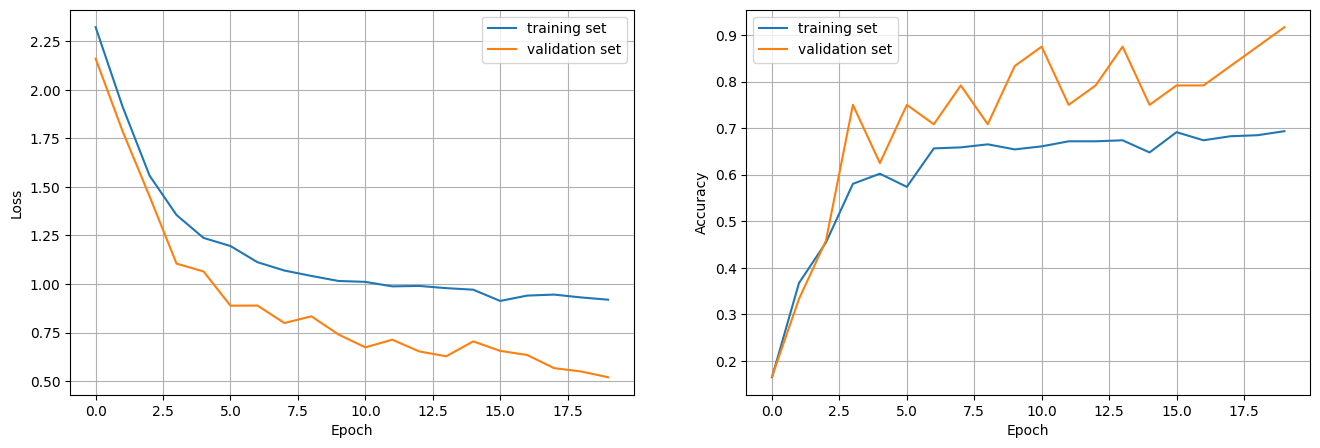

In [77]:
# Plot the training process:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(training_info.history['loss'], label="training set")
axs[0].plot(training_info.history['val_loss'], label="validation set")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].grid(True)
axs[0].legend()
try:
  axs[1].plot(training_info.history['accuracy'], label="training set")
  axs[1].plot(training_info.history['val_accuracy'], label="validation set")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Accuracy")
  axs[1].grid(True)
  axs[1].legend()
except:
  pass
plt.show()

#close to optimal


---
(e) Experiment with changing the internal layer width, the number of training epochs and the learning rate. Can you find a configuration which improves on the best performance obtained in Exercise 2.3?

In [78]:
#(e)
#ANSWER
#Yes, from 0.66 to 0.83 on validation set when increasing hidden layer width to 64
#Changing the optimizer from sgd to adam does not improve the accuracy
#using early stopping set to 4 and decreasing hidden layers to a staggering 10 seems to work best as the accuracy reached ~0.92

(f) How could you implement [early stopping](https://en.wikipedia.org/wiki/Early_stopping) using Keras to avoid overfitting during training?

In [79]:
#(f)
#ANSWER
#>>> callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
# model = keras.models.Sequential([keras.layers.Dense(10)])
# model.compile(keras.optimizers.SGD(), loss='mse')
# history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5), epochs=10, batch_size=1, callbacks=[callback], verbose=0)
#len(history.history['loss'])  # Only 4 epochs are run.

(g) The configuration of the data used in Exercise 2.3 differs significantly from what was done in this exercise, both regarding input features and normalisation. (1) List the differences below and (2) discuss the rationale behind these alternatives. (3) Discuss the practical differences of these approaches when the system needs to be deployed.

Hint: It is necessary to consider the nature and variability of [formant frequencies](https://en.wikipedia.org/wiki/Formant) here.

In [80]:
#(g)
#(1)
# - Inclusion of height and gender as inputs vs not.
# - Normalisation of values by speaker vs not.

#(2)
# - Formant frequencies are scaled (vary) systematically by vocal tract length
# - Vocal tract lengths are significantly different between males and female (due to physical size differences)
# - Height may be an informative feature as it may indicate the relative size of individuals (which would be related to formant frequency variation)
# - In the previous exercise we did not consider gender and height but did normalise all values by speaker (which would similarly compensate)

#(3)
# - The Ex 2.3 model would need to get enough speech input to estimate the speaker statistics accurately before it can be expected to perform well.
# - The model in this exercise would need to know the gender and height measurement of the speaker (i.e. it cannot rely on speech data alone).